In [20]:

import os
import dotenv
from datetime import datetime
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)

dotenv.load_dotenv()

True

##### I have named the columns in the data files as this

In [21]:
checkout_time_bin_dict = {1: ['T0730_bicycling_(In Minutes)', 'T0730_transit_(In Minutes)'],
 2: ['T1200_bicycling_(In Minutes)', 'T1200_transit_(In Minutes)'],
 3: ['T1600_bicycling_(In Minutes)', 'T1600_transit_(In Minutes)'],
 4: ['T2015_bicycling_(In Minutes)', 'T2015_transit_(In Minutes)']}

##### I have transformed time bins in range(1,4)

In [22]:
df_merged = pd.read_parquet(os.path.join(os.environ['OUTPUT_PATH'], "Bike_Trips_With_Coordinates_Google.parquet"))

# remove duplicate column
df_merged.drop(columns=['Destination_Coordinates', 'Origin_Coordinates'], inplace=True)

### we are only interested in checkout_time_bin 1, 2, 3, 4
df_merged = df_merged[df_merged['checkout_time_bin'].isin([1,2,3,4])]

#### I have removed origin==destination but we lose a lot of data

In [23]:
### remove origin == destination
df_merged = df_merged[df_merged['Checkout_Kiosk_Coordinates'] != df_merged['Return_Kiosk_Coordinates']]

##### Remove all the row, where bikeshare data is `200%` or more than the google_maps predicted bicycling time

- I had to do this for loop because, i have combined the data for all time frame range(1, 4). Either we have a lot of files or either we need `groupby` `origin-dest-timebin` and then apply the function 

In [24]:
df_final = pd.DataFrame()
##### for each of the checkout_time_bin df if duration minute is greater than 200% of T0730_bicycling_(In Minutes)
for checkout_time_bin, df in df_merged.groupby('checkout_time_bin'):
    df.fillna(0, inplace=True)
    ### Filter out trips where the duration is greater than 200% of the google data
    df = df[df['Duration (Minutes)'] <= (df[checkout_time_bin_dict[checkout_time_bin][0]] * 2)].copy()

    ## append the weight of each trip to the df
    df = pd.merge(df, df.groupby(['Checkout_Kiosk_Coordinates', 'Return_Kiosk_Coordinates']).size().reset_index(name='count_per_time_bin'), on=['Checkout_Kiosk_Coordinates', 'Return_Kiosk_Coordinates'], how='left')

    ## 1/weight for individual trip
    df['weight'] = 1/df['count_per_time_bin']

    df_final = pd.concat([df_final, df])


##### I tried making all the names, similar 


In [25]:
def get_config(time_frame_index):
    config = {
        "columns_names": {
            "rw_data": "Duration (Minutes)", # data from bikeshare
            "google_bicycle_data": checkout_time_bin_dict[time_frame_index][0], # data from google
            "google_transit_data": checkout_time_bin_dict[time_frame_index][1], # data from google
            "weight": "weight",
            "weighted_rw_bicycle_data": "weighted_rw_bicycle_data_per_hour_group",
            "weighted_google_bicycle_data": "weighted_google_bicycle_data_per_hour_group",
            "weighted_google_transit_data": "weighted_google_transit_data_per_hour_group",
            "Weighted_avg_rw_bicycle_data": "Weighted_avg_rw_bicycle_data_per_hour_group",
            "Weighted_avg_google_bicycle_data": "Weighted_avg_google_bicycle_data_per_hour_group",
            "Weighted_avg_google_transit_data": "Weighted_avg_google_transit_data_per_hour_group",
        },
        "time_data": checkout_time_bin_dict[time_frame_index][0].split('_')[0]
    }

    return config

##### Using Weights
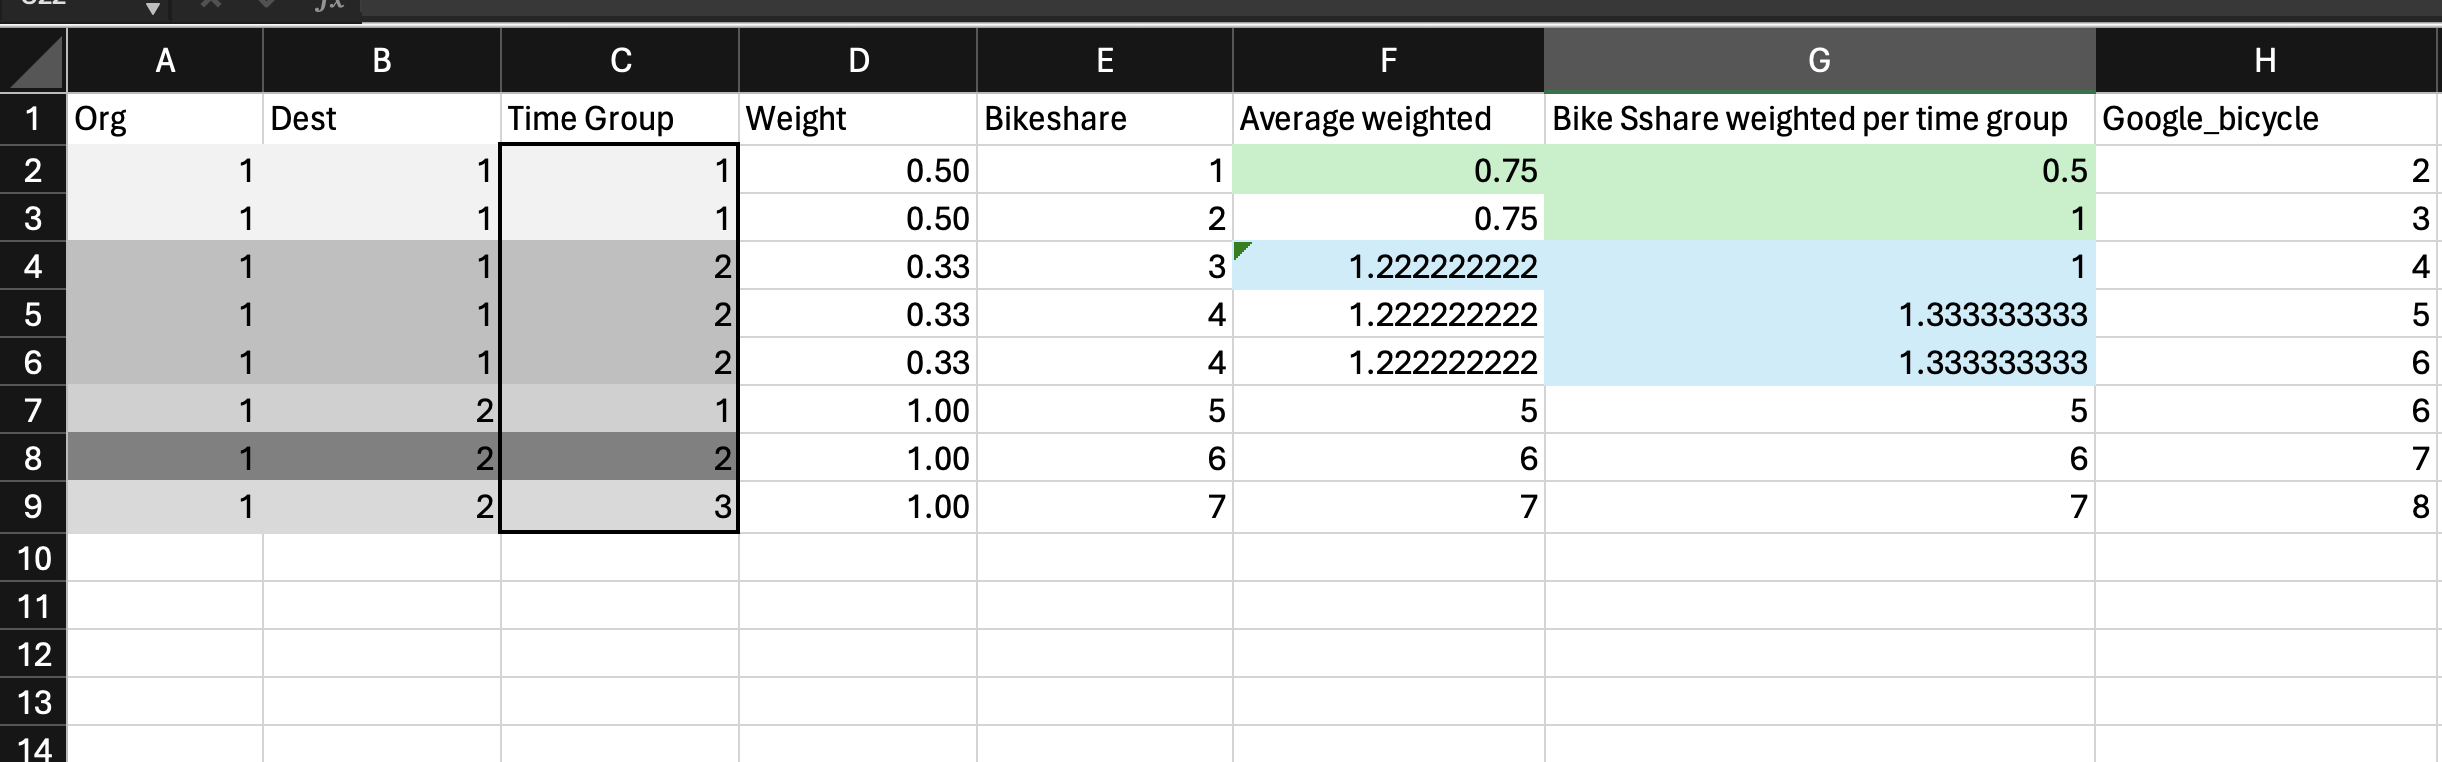

---
- Weight is calculated per each time bin, for each origin-destination pair


- First multipy transit, google_bicycling and bike_share by its corresponding weight
- then take weighted average of all the three

In [26]:


df_final_weighted = pd.DataFrame()
for i in checkout_time_bin_dict:
    df_final_bin = df_final[df_final['checkout_time_bin'] == i]
    df_final_bin_weighted = pd.DataFrame()  
    config = get_config(i)
    
    for orgDest, j in df_final_bin.groupby(['Checkout_Kiosk_Coordinates', 'Return_Kiosk_Coordinates']):

        # Calculated weighted travel time for each trip
        j[config['columns_names']['weighted_rw_bicycle_data']] = j[config['columns_names']['weight']] * j[config['columns_names']['rw_data']]
        j[config['columns_names']['weighted_google_bicycle_data']] = j[config['columns_names']['weight']] * j[config['columns_names']['google_bicycle_data']]
        j[config['columns_names']['weighted_google_transit_data']] = j[config['columns_names']['weight']] * j[config['columns_names']['google_transit_data']]

        # calculate the weighted average for each origin destination pair
        j[config['columns_names']['Weighted_avg_rw_bicycle_data']] = j[config['columns_names']['weighted_rw_bicycle_data']].sum() / j.shape[0]
        j[config['columns_names']['Weighted_avg_google_bicycle_data']] = j[config['columns_names']['weighted_google_bicycle_data']].sum() / j.shape[0]
        j[config['columns_names']['Weighted_avg_google_transit_data']] = j[config['columns_names']['weighted_google_transit_data']].sum() / j.shape[0]


        df_final_bin_weighted = pd.concat([df_final_bin_weighted, j])

    df_final_weighted = pd.concat([df_final_weighted, df_final_bin_weighted])

#### Tried to visualize the difference in travel time between all 3 data set, by time bin 

In [27]:
## Test one origin destination pair
origin_coordinates = "41.24333,-95.90808"
destination_coordinates = "41.24556,-95.95586"

df_org_dest = df_final_weighted[(df_final_weighted['Checkout_Kiosk_Coordinates'] == origin_coordinates) & (df_final_weighted['Return_Kiosk_Coordinates'] == destination_coordinates)]

org_kiosk = df_org_dest['Checkout Kiosk'].unique()[0]
dest_kiosk = df_org_dest['Return Kiosk'].unique()[0]

df_org_dest[['Checkout_Kiosk_Coordinates', 'Return_Kiosk_Coordinates', 'checkout_time_bin', 'Weighted_avg_rw_bicycle_data_per_hour_group', 'Weighted_avg_google_bicycle_data_per_hour_group', 'Weighted_avg_google_transit_data_per_hour_group']].drop_duplicates()

,Checkout_Kiosk_Coordinates,Return_Kiosk_Coordinates,checkout_time_bin,Weighted_avg_rw_bicycle_data_per_hour_group,Weighted_avg_google_bicycle_data_per_hour_group,Weighted_avg_google_transit_data_per_hour_group
2531,"41.24333,-95.90808","41.24556,-95.95586",2,20.250000,16.900000,49.350000
2564,"41.24333,-95.90808","41.24556,-95.95586",3,5.775510,4.828571,14.100000
1606,"41.24333,-95.90808","41.24556,-95.95586",4,3.055556,2.816667,8.558333


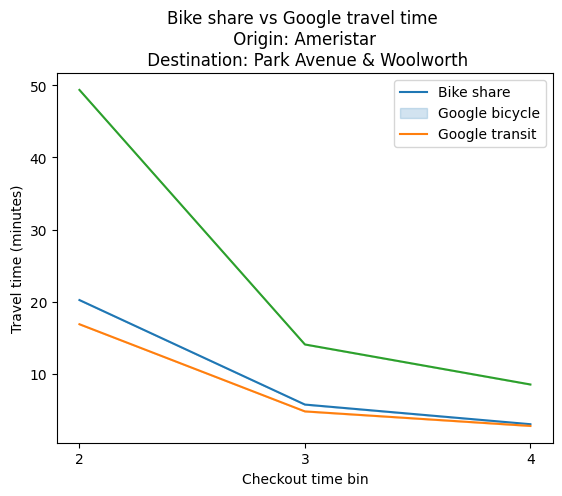

In [28]:
import seaborn as sns

#plot checkout_time_bin in x-axis and 3 lines for the 3 different travel times
fig, ax = plt.subplots()
#make the x-axis exact number not a series
ax.set_xticks(df_org_dest['checkout_time_bin'].unique())

sns.lineplot(data=df_org_dest, x='checkout_time_bin', y='Weighted_avg_rw_bicycle_data_per_hour_group', ax=ax)
sns.lineplot(data=df_org_dest, x='checkout_time_bin', y='Weighted_avg_google_bicycle_data_per_hour_group', ax=ax)
sns.lineplot(data=df_org_dest, x='checkout_time_bin', y='Weighted_avg_google_transit_data_per_hour_group', ax=ax)
ax.set_title(f'Bike share vs Google travel time \n Origin: {org_kiosk} \n Destination: {dest_kiosk}')
ax.set_ylabel('Travel time (minutes)')
ax.set_xlabel('Checkout time bin')
ax.legend(['Bike share', 'Google bicycle', 'Google transit'])
plt.show()


In [29]:
## Stats pf the final df
df_final_weighted[['Checkout_Kiosk_Coordinates', 'Return_Kiosk_Coordinates', 'Weighted_avg_rw_bicycle_data_per_hour_group', 'Weighted_avg_google_bicycle_data_per_hour_group', 'Weighted_avg_google_transit_data_per_hour_group']].describe()

,Weighted_avg_rw_bicycle_data_per_hour_group,Weighted_avg_google_bicycle_data_per_hour_group,Weighted_avg_google_transit_data_per_hour_group
count,101045.000000,101045.000000,101045.000000
mean,2.621502,2.347393,3.327065
std,6.888213,6.075589,7.821710
min,0.002232,0.001774,0.000000
25%,0.135333,0.125510,0.219820
50%,0.500000,0.447826,0.806061
75%,1.755102,1.584028,2.650000
max,206.000000,218.600000,406.133333


### How does travel time vary with time group?

In [30]:
df_weighted_avg = df_final_weighted[['Checkout_Kiosk_Coordinates', 'Return_Kiosk_Coordinates', 'Weighted_avg_rw_bicycle_data_per_hour_group', 'Weighted_avg_google_bicycle_data_per_hour_group', 'Weighted_avg_google_transit_data_per_hour_group','checkout_time_bin']].copy()
df_weighted_avg.drop_duplicates(inplace=True)
df_weighted_avg

,Checkout_Kiosk_Coordinates,Return_Kiosk_Coordinates,Weighted_avg_rw_bicycle_data_per_hour_group,Weighted_avg_google_bicycle_data_per_hour_group,Weighted_avg_google_transit_data_per_hour_group,checkout_time_bin
576,"41.13997,-96.06433","41.14896,-95.96814",43.000000,35.666667,0.000000,1
2154,"41.13997,-96.06433","41.15487,-96.1124",3.388889,3.675000,0.000000,1
5546,"41.13997,-96.06433","41.15593,-96.05576",3.444444,3.750000,12.116667,1
3999,"41.13997,-96.06433","41.15633,-96.04319",15.000000,14.866667,48.666667,1
575,"41.14896,-95.96814","41.13997,-96.06433",37.000000,38.850000,0.000000,1
...,...,...,...,...,...,...
3088,"41.30981,-95.95684","41.27207,-95.97327",15.000000,23.466667,48.466667,4
1162,"41.31615,-95.95626","41.25231,-95.97271",31.250000,18.375000,27.850000,4
1386,"41.31615,-95.95626","41.25639,-95.92966",26.000000,31.550000,35.750000,4
1700,"41.31615,-95.95626","41.25659,-95.95856",30.000000,31.750000,28.566667,4


In [31]:
pivot_table = df_weighted_avg.pivot_table(index=['Checkout_Kiosk_Coordinates', 'Return_Kiosk_Coordinates'], columns='checkout_time_bin', values=['Weighted_avg_rw_bicycle_data_per_hour_group', 'Weighted_avg_google_bicycle_data_per_hour_group', 'Weighted_avg_google_transit_data_per_hour_group'], aggfunc='mean')
pivot_table.columns = [f'{col[0]}_{col[1]}' for col in pivot_table.columns]
pivot_table.fillna(0, inplace=True)
pivot_table.reset_index(inplace=True)

Naming for difference columns

- Name = diff_{A}_ {B} _ hourly _ time_bin_number
- Values = Col_A-Col_B

In [32]:
for i in range(2, len(checkout_time_bin_dict)+1):

    ## Hourly change
    pivot_table[f'diff_google_bicycle_hourly_{i}-{i-1}'] = abs(pivot_table[f'Weighted_avg_google_bicycle_data_per_hour_group_{i}'] - pivot_table[f'Weighted_avg_google_bicycle_data_per_hour_group_{i-1}'])
    pivot_table[f'diff_google_transit_hourly_{i}-{i-1}'] = abs(pivot_table[f'Weighted_avg_google_transit_data_per_hour_group_{i}'] - pivot_table[f'Weighted_avg_google_transit_data_per_hour_group_{i-1}'])
    pivot_table[f'diff_rw_bicycle_hourly_{i}-{i-1}'] = abs(pivot_table[f'Weighted_avg_rw_bicycle_data_per_hour_group_{i}'] - pivot_table[f'Weighted_avg_rw_bicycle_data_per_hour_group_{i-1}'])

for i in range(1, len(checkout_time_bin_dict)+1):
    ### Google bicycle - rw bicycle
    pivot_table[f'diff_google_rw_bicycle_hourly_{i}'] = pivot_table[f'Weighted_avg_google_bicycle_data_per_hour_group_{i}'] - pivot_table[f'Weighted_avg_rw_bicycle_data_per_hour_group_{i}']

    ### Google transit - rw bicycle
    pivot_table[f'diff_google_rw_transit_hourly_{i}'] = pivot_table[f'Weighted_avg_google_transit_data_per_hour_group_{i}'] - pivot_table[f'Weighted_avg_rw_bicycle_data_per_hour_group_{i}']

In [35]:
pivot_table

,Checkout_Kiosk_Coordinates,Return_Kiosk_Coordinates,Weighted_avg_google_bicycle_data_per_hour_group_1,Weighted_avg_google_bicycle_data_per_hour_group_2,Weighted_avg_google_bicycle_data_per_hour_group_3,Weighted_avg_google_bicycle_data_per_hour_group_4,Weighted_avg_google_transit_data_per_hour_group_1,Weighted_avg_google_transit_data_per_hour_group_2,Weighted_avg_google_transit_data_per_hour_group_3,Weighted_avg_google_transit_data_per_hour_group_4,Weighted_avg_rw_bicycle_data_per_hour_group_1,Weighted_avg_rw_bicycle_data_per_hour_group_2,Weighted_avg_rw_bicycle_data_per_hour_group_3,Weighted_avg_rw_bicycle_data_per_hour_group_4,diff_google_bicycle_hourly_2-1,diff_google_transit_hourly_2-1,diff_rw_bicycle_hourly_2-1,diff_google_bicycle_hourly_3-2,diff_google_transit_hourly_3-2,diff_rw_bicycle_hourly_3-2,diff_google_bicycle_hourly_4-3,diff_google_transit_hourly_4-3,diff_rw_bicycle_hourly_4-3,diff_google_rw_bicycle_hourly_1,diff_google_rw_transit_hourly_1,diff_google_rw_bicycle_hourly_2,diff_google_rw_transit_hourly_2,diff_google_rw_bicycle_hourly_3,diff_google_rw_transit_hourly_3,diff_google_rw_bicycle_hourly_4,diff_google_rw_transit_hourly_4
0,"41.13997,-96.06433","41.14896,-95.96814",35.666667,7.133333,7.133333,0.000000,0.000000,0.000000,0.000000,0.000000,43.000000,7.760000,8.800000,0.000000,28.533333,0.000000,35.240000,0.000000,0.000000,1.040000,7.133333,0.000000,8.800000,-7.333333,-43.000000,-0.626667,-7.760000,-1.666667,-8.800000,0.000000,0.000000
1,"41.13997,-96.06433","41.15487,-96.1124",3.675000,7.350000,1.575000,1.002273,0.000000,0.000000,0.000000,0.000000,3.388889,5.888889,1.816327,1.243802,3.675000,0.000000,2.500000,5.775000,0.000000,4.072562,0.572727,0.000000,0.572525,0.286111,-3.388889,1.461111,-5.888889,-0.241327,-1.816327,-0.241529,-1.243802
2,"41.13997,-96.06433","41.15593,-96.05576",3.750000,0.592105,0.489130,0.255682,12.116667,1.913158,1.580435,0.826136,3.444444,0.681440,0.625709,0.306302,3.157895,10.203509,2.763004,0.102975,0.332723,0.055732,0.233449,0.754298,0.319407,0.305556,8.672222,-0.089335,1.231717,-0.136578,0.954726,-0.050620,0.519835
3,"41.13997,-96.06433","41.15633,-96.04319",14.866667,2.123810,2.477778,0.825926,48.666667,6.952381,8.111111,2.703704,15.000000,2.489796,3.222222,1.160494,12.742857,41.714286,12.510204,0.353968,1.158730,0.732426,1.651852,5.407407,2.061728,-0.133333,33.666667,-0.365986,4.462585,-0.744444,4.888889,-0.334568,1.543210
4,"41.13997,-96.06433","41.27159,-95.9306",0.000000,90.416667,90.416667,90.416667,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,55.000000,60.000000,90.416667,0.000000,60.000000,0.000000,0.000000,5.000000,0.000000,0.000000,5.000000,0.000000,0.000000,30.416667,-60.000000,35.416667,-55.000000,30.416667,-60.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5686,"41.31615,-95.95626","41.27775,-95.95669",0.000000,19.116667,0.000000,0.000000,0.000000,19.733333,0.000000,0.000000,0.000000,13.000000,0.000000,0.000000,19.116667,19.733333,13.000000,19.116667,19.733333,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.116667,6.733333,0.000000,0.000000,0.000000,0.000000
5687,"41.31615,-95.95626","41.2849,-96.0095",35.616667,0.000000,0.000000,0.000000,45.583333,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,35.616667,45.583333,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14.383333,-4.416667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5688,"41.31615,-95.95626","41.28554,-96.00497",34.533333,0.000000,0.000000,0.000000,46.000000,0.000000,0.000000,0.000000,43.000000,0.000000,0.000000,0.000000,34.533333,46.000000,43.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.466667,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5689,"41.31615,-95.95626","41.28661,-95.94713",0.000000,0.000000,12.283333,0.000000,0.000000,0.000000,28.016667,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,12.2833

#### Percentage of transit faster than bikeshare bicycling time

In [37]:
### Google transit - rw bicycle
cols = ["Checkout_Kiosk_Coordinates", "Return_Kiosk_Coordinates"] + [f'diff_google_rw_transit_hourly_{i}' for i in range(1, len(checkout_time_bin_dict)+1)] 
df_google_transit_rw_bicycle = pivot_table[cols].copy()
df_google_transit_rw_bicycle

data_cols = [f'diff_google_rw_transit_hourly_{i}' for i in range(1, len(checkout_time_bin_dict)+1)] 
# for i in data_cols:
#     ## check if the difference is greater than 0
#     df_google_transit_rw_bicycle[i] = np.where(df_google_transit_rw_bicycle[i] > 0, 1, 0)

df_google_transit_rw_bicycle.describe()




,diff_google_rw_transit_hourly_1,diff_google_rw_transit_hourly_2,diff_google_rw_transit_hourly_3,diff_google_rw_transit_hourly_4
count,5691.000000,5691.000000,5691.000000,5691.000000
mean,0.904310,1.061051,1.045776,1.953764
std,8.313388,9.596966,9.271614,9.511079
min,-118.000000,-206.000000,-160.000000,-70.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.191667,1.752160,1.568333,2.047917
max,101.266667,80.733333,95.533333,396.133333


#### Hourly change in time taken to travel from origin to destination by bikeshare bicycling time 

In [34]:
#### Google bicycle - rw bicycle
cols = ["Checkout_Kiosk_Coordinates", "Return_Kiosk_Coordinates"] + [f'diff_google_rw_bicycle_hourly_{i}' for i in range(1, len(checkout_time_bin_dict)+1)] 
df_google_bicycle_rw_bicycle = pivot_table[cols].copy()


df_google_bicycle_rw_bicycle

,Checkout_Kiosk_Coordinates,Return_Kiosk_Coordinates,diff_google_rw_bicycle_hourly_1,diff_google_rw_bicycle_hourly_2,diff_google_rw_bicycle_hourly_3,diff_google_rw_bicycle_hourly_4
0,"41.13997,-96.06433","41.14896,-95.96814",-7.333333,-0.626667,-1.666667,0.000000
1,"41.13997,-96.06433","41.15487,-96.1124",0.286111,1.461111,-0.241327,-0.241529
2,"41.13997,-96.06433","41.15593,-96.05576",0.305556,-0.089335,-0.136578,-0.050620
3,"41.13997,-96.06433","41.15633,-96.04319",-0.133333,-0.365986,-0.744444,-0.334568
4,"41.13997,-96.06433","41.27159,-95.9306",0.000000,30.416667,35.416667,30.416667
...,...,...,...,...,...,...
5686,"41.31615,-95.95626","41.27775,-95.95669",0.000000,6.116667,0.000000,0.000000
5687,"41.31615,-95.95626","41.2849,-96.0095",-14.383333,0.000000,0.000000,0.000000
5688,"41.31615,-95.95626","41.28554,-96.00497",-8.466667,0.000000,0.000000,0.000000
5689,"41.31615,-95.95626","41.28661,-95.94713",0.000000,0.000000,0.283333,0.000000


----
